In [24]:
import pandas as pd
from sql_functions import create_db_connection, execute_query, read_query
import plotly.express as px 
import plotly.graph_objects as go

#connect to database
pw = "Queens2021!"
connection = create_db_connection("localhost", "root", pw, "usports")

MySQL Database connection successful


In [76]:
#for placing text in multiple positions on scatter plot to reduce overlap
def improve_text_position(x):
    """ it is more efficient if the x values are sorted """
    # fix indentation 
    positions = ['top center', 'bottom center']  # you can add more: left center ...
    return [positions[i % len(positions)] for i in range(len(x))]

#### Look at top 20 rebounding averages

In [77]:
q = """
SELECT season, minutes_pgame, reb, 40/minutes_pgame AS multiplier, name, team
FROM players
NATURAL JOIN player_ballcontrol
NATURAL JOIN player_info
WHERE games_played > 10
ORDER BY reb DESC
LIMIT 20
"""

result = read_query(connection, q, None)
result
df = pd.DataFrame(result, columns=['Season', 'mpg', 'reb', 'multiplier', 'Player', 'Team'])
df['adjusted reb'] = df['reb']*df['multiplier']
df

,Season,mpg,reb,multiplier,Player,Team,adjusted reb
0,2023,33.3,16.6,1.201201,Kiyara Letlow,capebreton,19.939940
1,2022,33.8,15.7,1.183432,Kiyara Letlow,capebreton,18.579882
2,2015,33.3,15.3,1.201201,Sarah Wierks,ufv,18.378379
3,2022,30.2,15.0,1.324503,Carolina De Santo,upei,19.867549
4,2018,26.1,14.1,1.532567,Leashja Grant,lakehead,21.609195
5,2019,28.9,13.3,1.384083,Carolina De Santo,upei,18.408305
6,2019,34.6,12.7,1.156069,Vasiliki Louka,unbc,14.682082
7,2023,28.6,12.6,1.398601,Claire Signatovich,alberta,17.622377
8,2019,32.4,12.6,1.234568,Hannah Brown,capebreton,15.555555
9,2019,25.7,12.5,1.556420,Leashja Grant,lakehead,19.455252


Compare per game rebounding with per 40 minutes rebounding for those with top 20 reb/g

In [78]:
df = df.sort_values(by=['reb'])

fig = px.scatter(df, 'reb', 'adjusted reb', text='Player')
fig.update_layout(width=1000, height=800, template='plotly_dark', 
                  title='Top 20 Rebounding Averages', title_x=0.5,
                  xaxis_title="Rebounds Per Game", yaxis_title="Rebounds Per 40 minutes")
fig.update_traces(textfont_size=11, marker=dict(size=10), textposition=improve_text_position(df['reb']))
fig.show()

Visualize top 20 reb/g by season

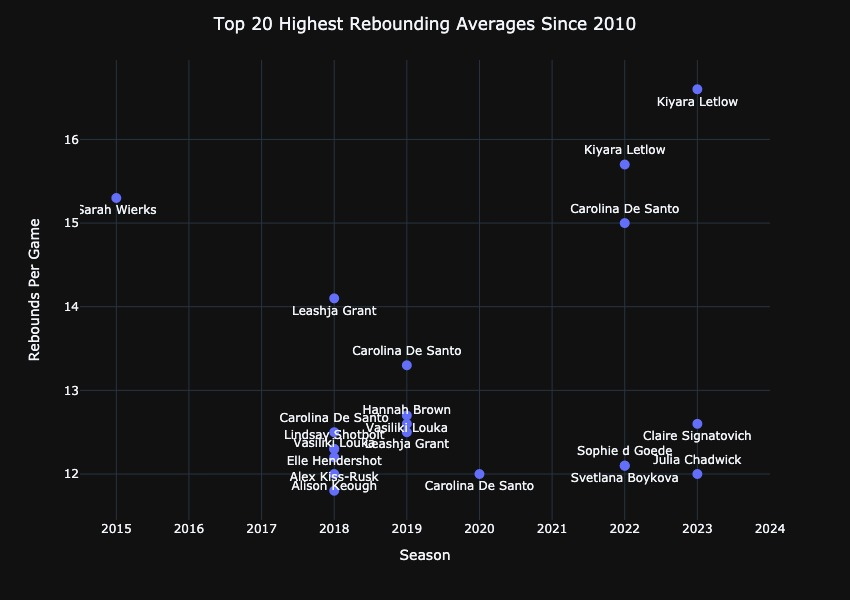

In [79]:
df = df.sort_values(by=['reb'])
fig = px.scatter(df, x="Season", y="reb", text="Player")
fig.update_traces(textposition=improve_text_position(df['reb']),  textfont_size=12, marker=dict(size=10))
fig.update_layout(
    width=850,
    height=600,
    title_text='Top 20 Highest Rebounding Averages Since 2010',
    template='plotly_dark',
    title_x=0.5,
    yaxis_title='Rebounds Per Game'
)
fig.update_xaxes(range=[2014.5,2024])
fig.show('jpg')

#save Figure as jpg image
fig.write_image("images/rebounds/top20rebounders.jpeg", scale=6)

19/20 of the top 20 rebounders occurred since 2018 

look at the top 10 rebounders of each season to see how that's changed

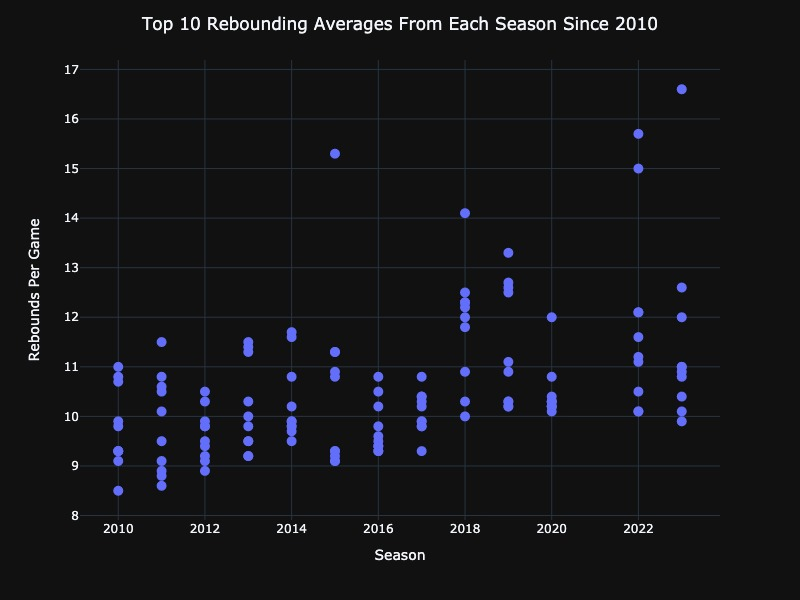

In [80]:
q = """
    SELECT season, reb, season_rank
    FROM (  SELECT player_ballcontrol.*,
                row_number() OVER (PARTITION BY season ORDER BY reb DESC) AS season_rank
            FROM player_ballcontrol
            NATURAL JOIN player_info
            WHERE games_played > 10
          ) player_ballcontrol
    WHERE season_rank >= 1 AND season_rank <= 10
"""

result = read_query(connection, q, None)
result
top_reb_df = pd.DataFrame(result, columns=['Season', 'reb', 'season rank'])

top_reb_df = top_reb_df.sort_values(by=['reb'], ascending=False, ignore_index=True)

#fig = px.scatter(top_reb_df, x='Season', y='reb', color='top_reb_df.index')
fig = px.scatter(top_reb_df, x='Season', y='reb')
fig.update_coloraxes(reversescale=True)
fig.update_traces(marker=dict(size=10))
fig.update_layout(width=800, height=600, template='plotly_dark', 
                  title='Top 10 Rebounding Averages From Each Season Since 2010',
                  yaxis_title="Rebounds Per Game",
                  title_x=0.5, coloraxis_colorbar_title_text='Overall Rank')
fig.show('jpg')

#save Figure as jpg image
fig.write_image("images/rebounds/top10rebounders_byseason.jpeg", scale=6)

From above:
- Number of rebounds top rebounders are getting have increased
- in last 5 seasons, it's rare to have a top 10 rebounder average less than 10, whereas it was common prior to 2018
Thoughts:
- have teams reboundings styles changed? Box out and mainly one person goes and gets it (increasing one persons rebounds)
- are there more rebounds available? Previously showed that 3pt attempts are up, and pace of play has also increased (get data on this)

In [81]:
q = """
    SELECT season, team, fga, fga/games_played as fga_pgame, reb
    FROM team_splitstats
    WHERE split = 'total' 
    """
result = read_query(connection, q, None)

df = pd.DataFrame(result, columns=['Season', 'Team', 'fga', 'fga_pgame', 'reb'])
df

,Season,Team,fga,fga_pgame,reb
0,2010,acadia,1364.0,68.200000,34.8
1,2010,alberta,1232.0,61.600000,44.3
2,2010,bishops,966.0,60.375000,34.8
3,2010,brandon,1017.0,59.823529,36.4
4,2010,brock,1517.0,68.954545,34.4
...,...,...,...,...,...
587,2023,waterloo,1577.0,71.681818,43.5
588,2023,western,1530.0,69.545455,42.0
589,2023,windsor,1413.0,64.227273,40.9
590,2023,winnipeg,1409.0,70.450000,42.9


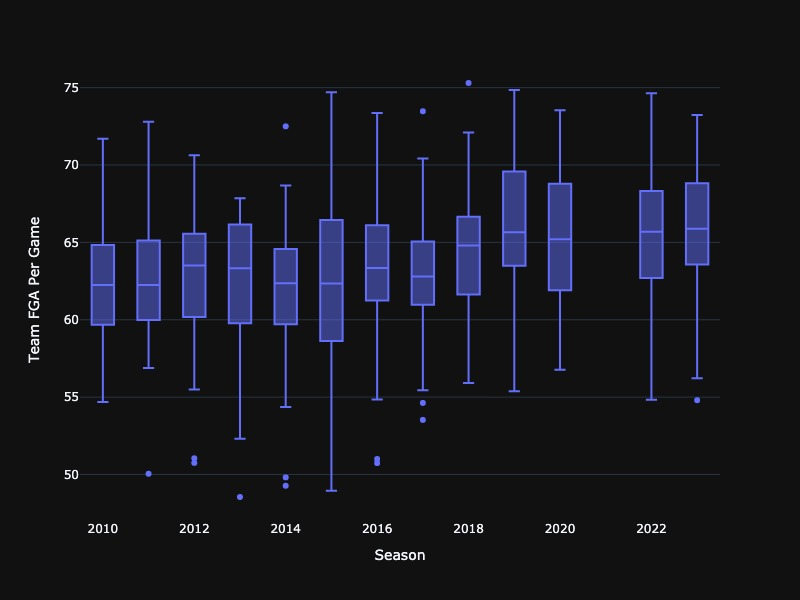

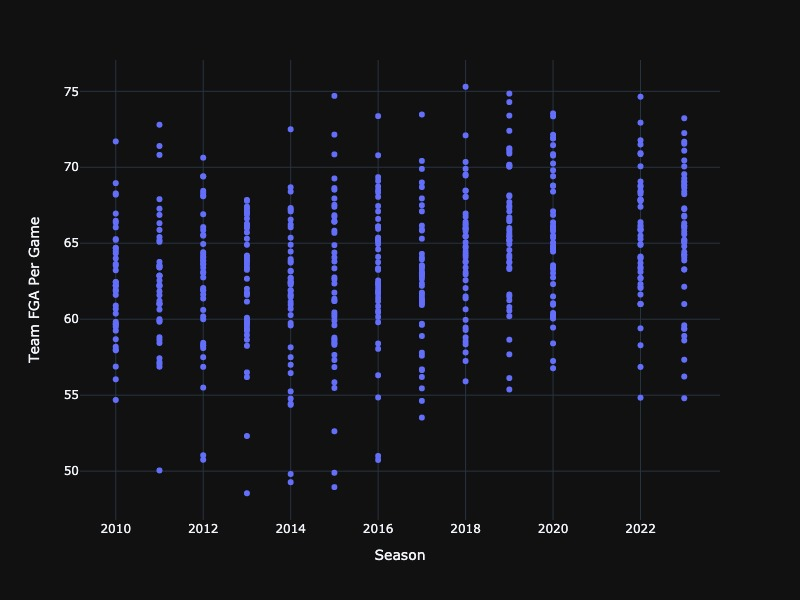

In [82]:
fig = px.box(df, x='Season', y='fga_pgame', width=800, height=600)
fig.update_layout(template='plotly_dark', yaxis_title='Team FGA Per Game')
fig.show('jpg')

#save Figure as jpg image
fig.write_image("images/rebounds/teamfga_byseason_box.jpeg", scale=6)

fig = px.scatter(df, x='Season', y='fga_pgame', width=800, height=600)
fig.update_layout(template='plotly_dark', yaxis_title='Team FGA Per Game')
fig.show('jpg')

#save Figure as jpg image
fig.write_image("images/rebounds/teamfga_byseason_scatter.jpeg", scale=6)


median shots/game have increased slightly

it's becoming more common for teams to average over 70 shots per game

In [83]:
fig = px.box(df, x='Season', y='reb', width=800, height=600)
fig.update_layout(template='plotly_dark')
fig.show()

- average rebounds per game have increased slightly when looking at median and max

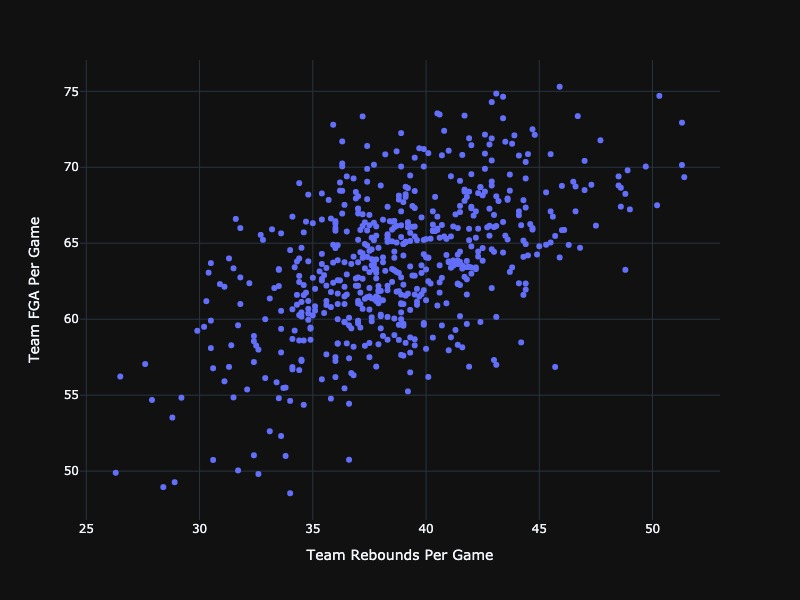

In [84]:
fig = px.scatter(df, x='reb', y='fga_pgame', width = 800, height = 600)
fig.update_layout(template='plotly_dark', yaxis_title='Team FGA Per Game', xaxis_title='Team Rebounds Per Game')
fig.show('jpg')

#save Figure as jpg image
fig.write_image("images/rebounds/teamfga_vs_teamreb.jpeg", scale=6)

teams that average more shot attempts per game, get more rebounds

- Do players who play on higher pace teams (ie get more shots) have a better chance at getting more rebounds?

In [85]:
#TODO: also look at percentage of teams rebounds players get (top 10 from each season). To compare whether top rebounders are getting more of the rebounds available in recent years, or if there are simply more rebounds to be gotten because of more shots

In [92]:
q = """
    SELECT t2.season, t2.reb, season_rank, t2.team, t2.name, team_splitstats.reb, t2.reb/team_splitstats.reb AS reb_share 
    FROM team_splitstats
    JOIN ( SELECT season, reb, season_rank, team, name
            FROM (  SELECT player_ballcontrol.*, team, name,
                    row_number() OVER (PARTITION BY season ORDER BY reb DESC) AS season_rank
                    FROM player_ballcontrol
                    NATURAL JOIN player_info
                    NATURAL JOIN players
                    WHERE games_played > 10
                ) t1
            WHERE season_rank >= 1 AND season_rank <= 10
        ) t2
    ON team_splitstats.team = t2.team AND team_splitstats.season = t2.season
    WHERE split = 'total';
    
"""

result = read_query(connection, q, None)
result
top_reb_df = pd.DataFrame(result, columns=['Season', 'player reb', 'season rank', 'team', 'name', 'team reb', 'player rebound share'])
top_reb_df

,Season,player reb,season rank,team,name,team reb,player rebound share
0,2010,11.0,1,toronto,Nicki Schutz,42.5,0.258824
1,2010,10.8,2,ottawa,Hannah Sunley-Paisley,39.2,0.275510
2,2010,10.7,3,laurentian,Darrah Bumstead,41.0,0.260976
3,2010,9.9,4,lakehead,Lindsay Druery,36.3,0.272727
4,2010,9.8,5,regina,Brittany Read,44.4,0.220721
...,...,...,...,...,...,...,...
125,2023,10.9,6,bishops,Jael Kabunda,43.0,0.253488
126,2023,10.8,7,carleton,Jacqueline Urban,42.1,0.256532
127,2023,10.4,8,york,Cyanna King,43.4,0.239631
128,2023,10.1,9,trinitywestern,Nicole Fransson,41.4,0.243961


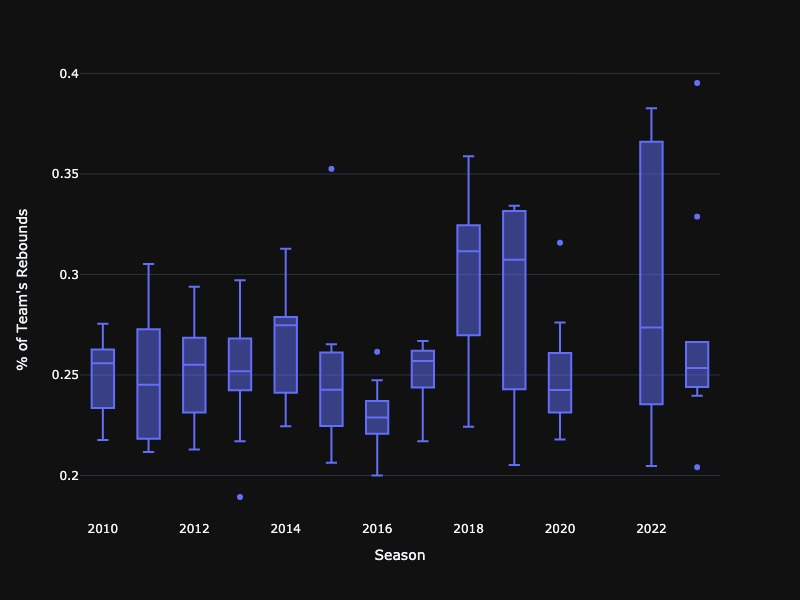

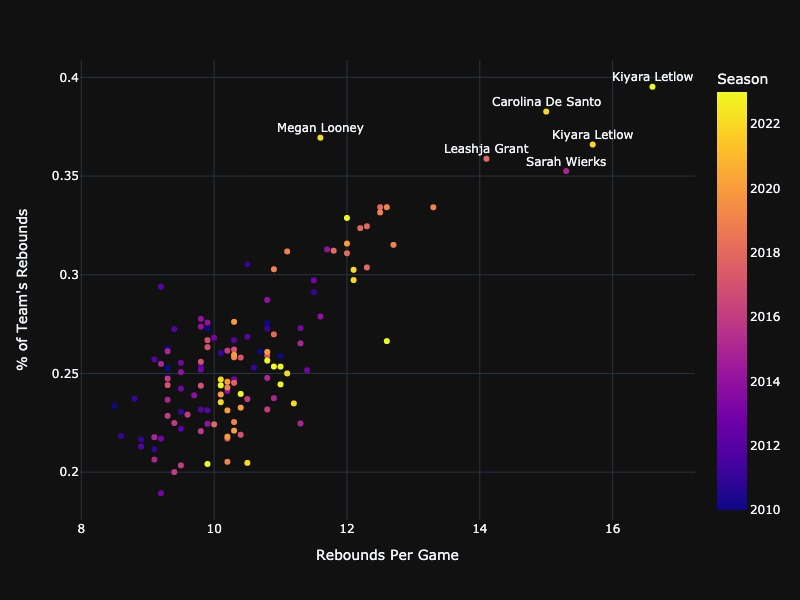

In [94]:
fig = px.box(top_reb_df, x='Season', y='player rebound share', width=800, height=600)
fig.update_layout(template='plotly_dark', yaxis_title="% of Team's Rebounds")
fig.show('jpg')
#save Figure as jpg image
fig.write_image("images/rebounds/percentteamreb_boxplot.jpeg", scale=6)

outliers = top_reb_df.loc[top_reb_df["player rebound share"] > 0.35, ["player reb", 'player rebound share', 'name']]
fig = px.scatter(top_reb_df, x='player reb', y='player rebound share', color = 'Season', width=800, height=600)
fig.update_layout(template='plotly_dark', xaxis_title="Rebounds Per Game", yaxis_title="% of Team's Rebounds")
## add text to outliers using their (x,y) coordinates:
for x,y,z in outliers.itertuples(index=False):
    fig.add_annotation(
        x=x, y=y,
        text=z,
        showarrow=False,
        yshift=10
    )
fig.show('jpg')
#save Figure as jpg image
fig.write_image("images/rebounds/percentteamreb_vs_playerreb.jpeg", scale=6)




- in three out of last 5 seasons, individual players have contributed to over 30% of a team's rebounds
- strong correlation between % of team's rebounds and rebounds per game

In [95]:
q = """
    SELECT fga/games_played AS fga_per_game, team, season,
    row_number() OVER (PARTITION BY season ORDER BY fga DESC) AS fga_season_rank
    FROM team_splitstats
    WHERE split = 'total';   
"""

result = read_query(connection, q, None)
result
fga_df = pd.DataFrame(result, columns=['fga per game', 'team', 'Season', 'team fga season rank'])
fga_df.iloc[1:10]

,fga per game,team,Season,team fga season rank
1,66.954545,lakehead,2010,2
2,66.045455,ottawa,2010,3
3,65.272727,carleton,2010,4
4,71.700000,stfx,2010,5
5,64.681818,toronto,2010,6
6,64.500000,ryerson,2010,7
7,63.636364,mcmaster,2010,8
8,62.454545,laurier,2010,9
9,68.200000,acadia,2010,10


In [96]:
top_reb_df

,Season,player reb,season rank,team,name,team reb,player rebound share
0,2010,11.0,1,toronto,Nicki Schutz,42.5,0.258824
1,2010,10.8,2,ottawa,Hannah Sunley-Paisley,39.2,0.275510
2,2010,10.7,3,laurentian,Darrah Bumstead,41.0,0.260976
3,2010,9.9,4,lakehead,Lindsay Druery,36.3,0.272727
4,2010,9.8,5,regina,Brittany Read,44.4,0.220721
...,...,...,...,...,...,...,...
125,2023,10.9,6,bishops,Jael Kabunda,43.0,0.253488
126,2023,10.8,7,carleton,Jacqueline Urban,42.1,0.256532
127,2023,10.4,8,york,Cyanna King,43.4,0.239631
128,2023,10.1,9,trinitywestern,Nicole Fransson,41.4,0.243961


In [97]:
final_df = fga_df.merge(top_reb_df, on=['team', 'Season'], how='inner')
final_df

,fga per game,team,Season,team fga season rank,player reb,season rank,name,team reb,player rebound share
0,66.954545,lakehead,2010,2,9.9,4,Lindsay Druery,36.3,0.272727
1,66.045455,ottawa,2010,3,10.8,2,Hannah Sunley-Paisley,39.2,0.275510
2,64.681818,toronto,2010,6,11.0,1,Nicki Schutz,42.5,0.258824
3,64.500000,ryerson,2010,7,9.3,7,Angela Tilk,37.5,0.248000
4,57.954545,laurentian,2010,18,10.7,3,Darrah Bumstead,41.0,0.260976
...,...,...,...,...,...,...,...,...,...
125,68.800000,regina,2023,22,9.9,10,Jade Belmore,48.5,0.204124
126,67.300000,capebreton,2023,26,16.6,1,Kiyara Letlow,42.0,0.395238
127,64.800000,unbc,2023,36,11.0,4,Sveta Boykova,45.0,0.244444
128,64.250000,trinitywestern,2023,37,10.1,9,Nicole Fransson,41.4,0.243961


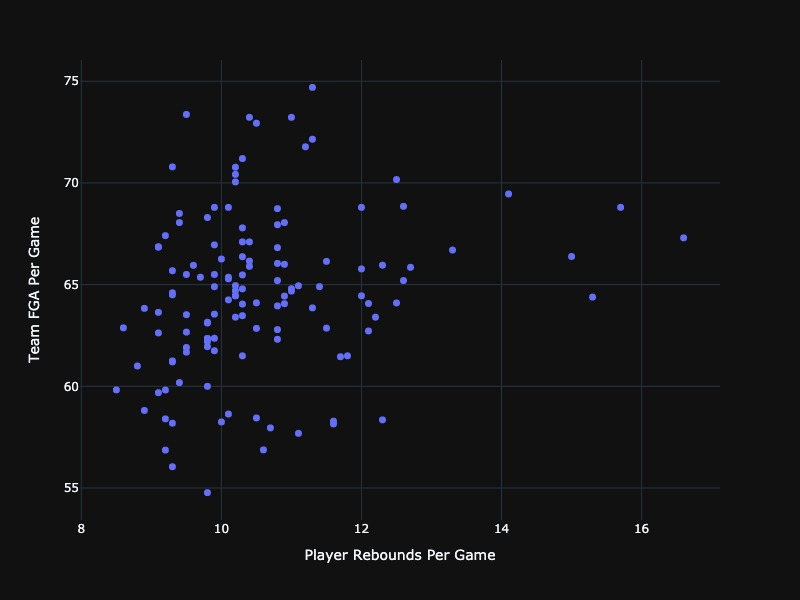

In [91]:
fig = px.scatter(final_df, x='player reb', y='fga per game', width=800, height=600)
fig.update_layout(template='plotly_dark', xaxis_title='Player Rebounds Per Game', yaxis_title='Team FGA Per Game')
fig.update_coloraxes(reversescale=True)
fig.update_traces(marker=dict(size=7))
fig.show('jpg')

#save Figure as jpg image
fig.write_image("images/rebounds/teamfga_vs_playerreb.jpeg", scale=6)


- no correlation between individual rebounds per game and team fga per game

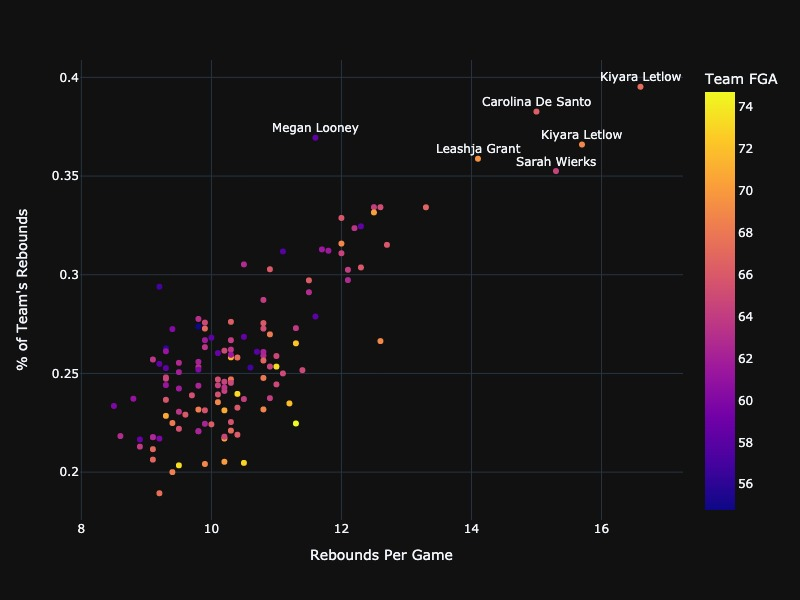

In [99]:
outliers = final_df.loc[final_df["player rebound share"] > 0.35, ["player reb", 'player rebound share', 'name']]
fig = px.scatter(final_df, x='player reb', y='player rebound share', color = 'fga per game', width=800, height=600)
fig.update_layout(template='plotly_dark', xaxis_title="Rebounds Per Game", yaxis_title="% of Team's Rebounds", coloraxis_colorbar_title_text='Team FGA')
# add text to outliers using their (x,y) coordinates:
for x,y,z in outliers.itertuples(index=False):
    fig.add_annotation(
        x=x, y=y,
        text=z,
        showarrow=False,
        yshift=10
    )
fig.show('jpg')

#save Figure as jpg image
fig.write_image("images/rebounds/percentteamreb_vs_playerreb2.jpeg", scale=6)